C:\Users\Thomas.Zoellinger\AppData\Local\Temp/ipykernel_59440/650562110.py:79: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  run.log('Kernel type', np.str(args.kernel))
C:\Users\Thomas.Zoellinger\AppData\Local\Temp/ipykernel_59440/650562110.py:80: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  run.log('Penalty', np.float(args.penalty))
C:\Users\Tho

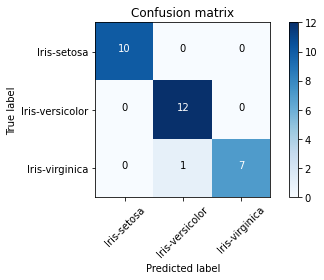

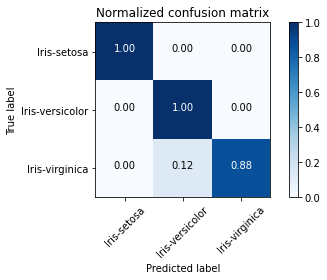

In [6]:
from azureml.core import Dataset, Run
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn import datasets
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np
import itertools
import argparse
import os


run = Run.get_context()

parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])

def log_confusion_matrix_image(cm, labels, normalize=False, log_name='confusion_matrix', title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    run.log_image(log_name, plot=plt)
    plt.savefig(os.path.join('outputs', '{0}.png'.format(log_name)))


def log_confusion_matrix(cm, labels):
    # log confusion matrix as object
    cm_json = {
        'schema_type': 'confusion_matrix',
        'schema_version': 'v1',
        'data': {
            'class_labels': labels,
            'matrix': cm.tolist()
        }
    }
    run.log_confusion_matrix('confusion_matrix', cm_json)

    # log confusion matrix as image
    log_confusion_matrix_image(cm, labels, normalize=False,
                               log_name='confusion_matrix_unnormalized', title='Confusion matrix')

    # log normalized confusion matrix as image
    log_confusion_matrix_image(
        cm, labels, normalize=True, log_name='confusion_matrix_normalized', title='Normalized confusion matrix')


def main(args):
    # create the outputs folder
    os.makedirs('outputs', exist_ok=True)

    # Log arguments
    run.log('Kernel type', np.str(args.kernel))
    run.log('Penalty', np.float(args.penalty))

    # Load iris dataset
    X, y = datasets.load_iris(return_X_y=True)

    # dividing X,y into train and test data
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=223)
    data = {'train': {'X': x_train, 'y': y_train},
            'test': {'X': x_test, 'y': y_test}}

    # train a SVM classifier
    svm_model = SVC(kernel=args.kernel, C=args.penalty, gamma='scale').fit(
        data['train']['X'], data['train']['y'])
    svm_predictions = svm_model.predict(data['test']['X'])

    # accuracy for X_test
    accuracy = svm_model.score(data['test']['X'], data['test']['y'])
    print('Accuracy of SVM classifier on test set: {:.2f}'.format(accuracy))
    run.log('Accuracy', np.float(accuracy))

    # precision for X_test
    precision = precision_score(
        svm_predictions, data["test"]["y"], average='weighted')
    print('Precision of SVM classifier on test set: {:.2f}'.format(precision))
    run.log('precision', precision)

    # recall for X_test
    recall = recall_score(
        svm_predictions, data["test"]["y"], average='weighted')
    print('Recall of SVM classifier on test set: {:.2f}'.format(recall))
    run.log('recall', recall)

    # f1-score for X_test
    f1 = f1_score(svm_predictions, data["test"]["y"], average='weighted')
    print('F1-Score of SVM classifier on test set: {:.2f}'.format(f1))
    run.log('f1-score', f1)

    # create a confusion matrix
    labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    labels_numbers = [0, 1, 2]
    cm = confusion_matrix(y_test, svm_predictions, labels_numbers)
    log_confusion_matrix(cm, labels)

    # files saved in the "outputs" folder are automatically uploaded into run history
    model_file_name = "model.pkl"
    joblib.dump(svm_model, os.path.join('outputs', model_file_name))


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--kernel', type=str, default='rbf',
                        help='Kernel type to be used in the algorithm')
    parser.add_argument('--penalty', type=float, default=1.0,
                        help='Penalty parameter of the error term')
    args = parser.parse_args("")
    return args


if __name__ == '__main__':
    args = parse_args()
    main(args=args)


In [5]:
%tb

SystemExit: 2